# Group 1: Project 1

### Title: Evaluating Tree-Based and Resampling Methods for Early Parkinson’s Disease Classification based on Biomedical Voice Measures

#### Introduction
Parkinson’s disease (PD), infamous for being a gradual neurodegenerative illness, affects millions of lives globally. Due to its progressive nature, especially with age, healthcare systems across nations have become increasingly strained as populations grow older. Early detection of PD is therefore inherently crucial, as timely interventions can significantly slow functional decline and improve the quality of life for both patients and their caregivers. Unfortunately, detecting PD early is challenging because its symptoms are subtle and difficult to quantify through conventional clinical measures. This is where Machine Learning (ML) approaches may offer meaningful contributions, particularly by leveraging non-invasive biomarkers. One well-known example is vocal signals, which are known to deteriorate early as PD progresses.

The dataset used in this project consists of individuals’ biomedical voice measurements, including both PD and non-PD subjects. Features such as harmonic-to-noise ratios, jitter, shimmer, and others have shown repeated evidence of being associated with vocal impairments commonly linked to PD. This dataset from Kaggle (https://www.kaggle.com/datasets/shreyadutta1116/parkinsons-disease) presents an opportunity to apply ML models capable of handling high-dimensional feature interactions and nonlinear relationships.

This project focuses on ML methods adjacent to the topics covered in Lectures 1–4, specifically:
- Decision Trees
- Bagging & Random Forests
- Gradient Boosting

These methods are well-suited for the Parkinson’s dataset because they
- (i) naturally capture nonlinear patterns,
- (ii) provide built-in feature selection, and
- (iii) are robust to heterogeneous input feature scales.

The objective of this project is clear: to investigate whether bootstrap-based inference and ensemble tree-based methods can produce trustworthy classification predictions for PD using vocal biomarkers. We will evaluate the stability, robustness, and performance of the selected methods, and ultimately discuss their strengths and limitations within the context of biomedical classification problems.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
import sklearn.model_selection as skm
import random
import os

from matplotlib.pyplot import subplots
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier   
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score

np.random.seed(14)
random.seed(14)
os.environ['PYTHONHASHSEED'] = str(14)

#### Literature Review

A substantial body of research investigates diagnosing Parkinson’s disease using speech signals, yet most studies focus on individual algorithms in isolation rather than examining the comparative value of ensemble methods (Chakole et al., 2025). At the dataset level, prior work has centered on extracted speech characteristics such as phonation, articulation, respiration, prosody, and resonance (Orozco-Arroyave, 2016). However, despite these advances, relatively little research directly compares ensemble methods with traditional algorithms when applied to Parkinson’s speech data.

In 2017, Orozco-Arroyave et al. introduced NeuroSpeech, a software framework for analyzing speech signals across phonation, articulation, prosody, and intelligibility. NeuroSpeech accomplished three objectives: modeling speech using these characteristics, classifying whether an individual has Parkinson’s disease, and assessing disease severity. The authors describe NeuroSpeech as the first known software dedicated to Parkinson’s assessment through speech.

Tracy et al. (2020) further explored the use of voice recordings to predict Parkinson’s disease using random forests, gradient boosted decision trees, and L2-regularized logistic regression. They emphasized the importance of using conventional, interpretable models for clinical settings and noted that neural networks typically require substantially larger datasets. Their results show that gradient boosting achieved the highest AUC (0.95), followed by random forests (0.94) and logistic regression (0.91). Across all models, precision exceeded recall, which the authors attribute to class imbalance during training. The most influential features for the gradient boosting model were fundamental frequency, the slope of pitch over time, and the first-order differential of the fundamental frequency.

In contrast to feature-engineered approaches, some studies train models directly on raw audio signals. For example, Narendra et al. (2021) compared an SVM trained on phonation, articulation, and prosody features with a neural network trained on raw audio. The engineered-feature model achieved a slightly higher accuracy (68.56%) than the raw-audio model (67.93%). Although the absolute performance was modest, the findings demonstrate that voice signals contain meaningful information for predicting Parkinson’s even when models operate directly on raw inputs.

More recently, Chakole et al. (2025) evaluated several models including Random Forest, KNN, Naive Bayes, Gradient Boosting, and XGBoost on vocal features such as pitch period entropy, detrended fluctuation analysis, recurring period density entropy, number of pulses and periods, mean periodic pulses, standard deviation of periodic pulses, and jitter. Prior to training, the authors provided descriptive statistics (mean, minimum, maximum) to enhance interpretability. Their results align with Tracy et al. (2020), with gradient boosting again outperforming all other models. The authors highlight pitch period entropy (PPE) and detrended fluctuation analysis (DFA) as particularly informative for identifying individuals with Parkinson’s.

Taken together, these studies consistently show that gradient boosting models outperform classical approaches by a clear margin, underscoring the underexplored potential of ensemble methods in speech-based Parkinson’s prediction.

#### Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv("parkinsons_disease.csv")

n_rows, n_cols = df.shape
status_counts = df['status'].value_counts()

n_rows, n_cols, status_counts

(1195,
 24,
 status
 1.000000    147
 0.000000     48
 0.877561      1
 0.726548      1
 0.743267      1
            ... 
 0.736271      1
 0.798377      1
 0.771907      1
 0.704315      1
 0.735387      1
 Name: count, Length: 1002, dtype: int64)

We begin our EDA (Exploratory Data Analysis) by loading the Kaggle PD dataset, and inspecting its dimensions. The dataset contains 1195 observations and 24 features, including the target variable ```status```, indicating whether the patient has Parkinson's disease. To further understand our target variable, we computed the frequency of each unique value in ```status```. The results reveal 147 instances labeled 1 (Parkinson's), and 48 instances labeled 0 (healthy), while the remaining observations are fractional values between 0 and 1. This finding is unexpected, as the dataset composition describes ```status``` as a binary variable, suggesting further examinations of the target variable.

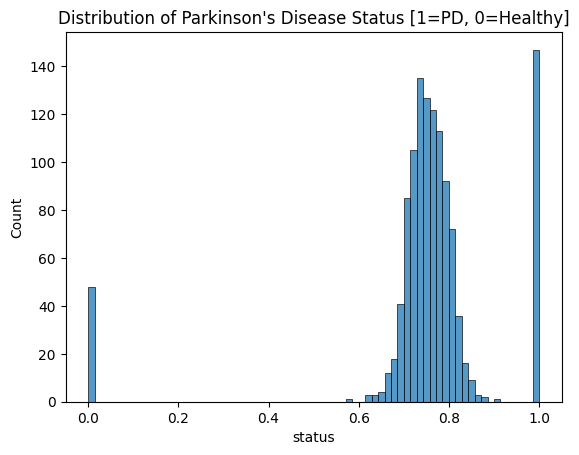

In [3]:
sns.histplot(x=df['status'])
plt.title("Distribution of Parkinson's Disease Status [1=PD, 0=Healthy]")
plt.show()

By visualizing the distribution of the Parkinson's Disease status column, we aim to better understand the nature of the core response variable. Apparently in its raw form, `status` does not consist solely binary labels but instead have continuous values ranging approximately between 0.6 to 0.9. We found it beneficial to convert all these probabilistic estimates to binary labels for our goal of supervised classification by mapping status == 1 to be subjects of Parkinson's Disease and all other values < 1 to be considered healthy people, as seen in the modelling section of this paper. This is because the original dataset found in the UC Irvine Machine Learning Repository suggested it is of type interger, which means these values are likely assigned sythentically by the Kaggle creator for their own purposes (UCI Machine Learning Repository, n.d.). 

Subsequently, that also means there are far more Parkinson's Disease patients than healthy subjects in our dataset. To be specific, there would be 147 (12.3%) PD subjects and 1048 (87.70%) healthy persons in our dataset. While this is common for biomedical data in general, such strong class imbalance suggests metrics beyond accuracy, instead metrics such as ROC-AUC and Precision-Recall curves would be more practical, in which we will see in the Results and Discussion section.

In [4]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,...,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000
mean,154.312848,197.246916,116.332971,0.006221,0.000044,0.003306,0.003428,0.009920,0.029671,0.282587,...,0.047084,0.024880,21.895992,0.754117,0.498054,0.718214,-5.683541,0.226451,2.382126,0.206771
std,17.124313,37.804828,17.953210,0.002001,0.000014,0.001228,0.001140,0.003678,0.007781,0.080554,...,0.012609,0.016717,1.829752,0.178176,0.043021,0.022905,0.451130,0.034527,0.157783,0.037229
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,150.616420,189.666263,112.204966,0.005769,0.000041,0.003012,0.003173,0.009089,0.027992,0.264388,...,0.044325,0.020837,21.550002,0.726172,0.489091,0.713742,-5.779205,0.219263,2.351569,0.199061
50%,154.117666,197.198334,116.100612,0.006188,0.000044,0.003282,0.003397,0.009845,0.029575,0.280555,...,0.046820,0.024486,21.913050,0.758665,0.497781,0.718387,-5.681992,0.226621,2.382482,0.207056
75%,157.491303,204.071906,119.290367,0.006557,0.000046,0.003530,0.003618,0.010552,0.031008,0.296840,...,0.049418,0.027661,22.274815,0.797437,0.506417,0.722957,-5.595197,0.232901,2.411210,0.213564
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


To gain an understanding of the features in our dataset, we computed descriptive statistics of the variables, such as the mean, standard deviation and quaritles. We observed that there are differences in feature scales and considerable variability across variables. Since most tree-based algorithms are insensitive to scales, we do not apply any standardization and normalization techniques to the data.

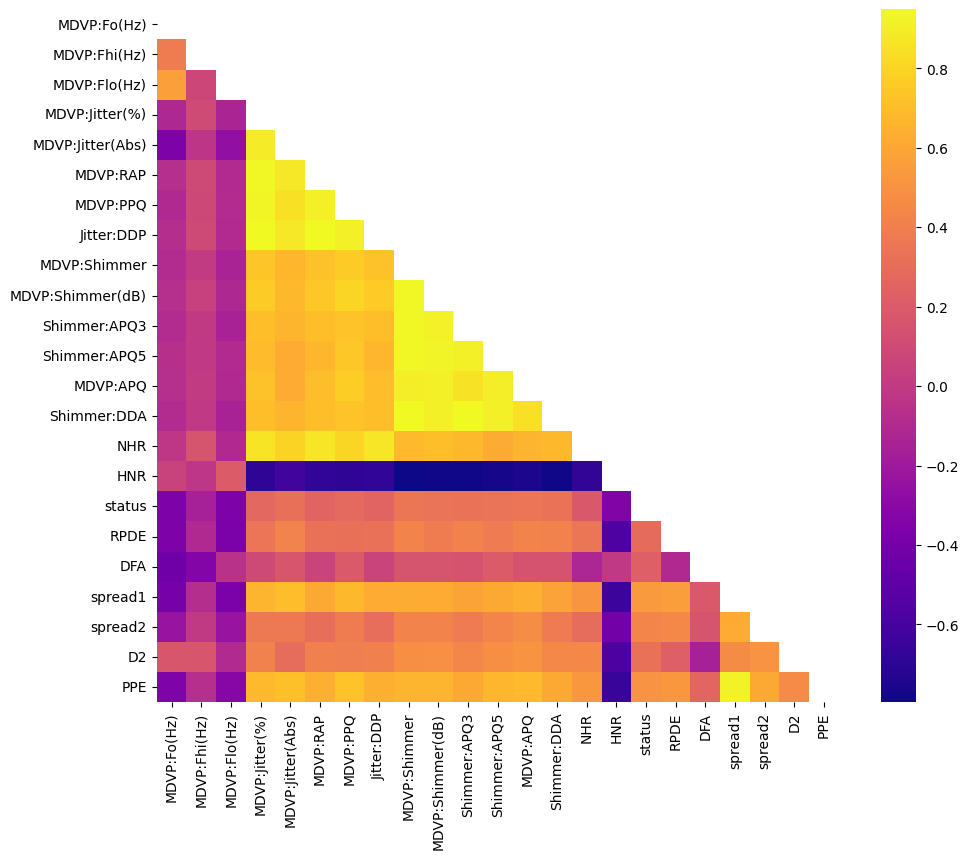

In [5]:
df_num = df.drop(columns=['name'])
corr = df_num.corr()

f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap = 'plasma', mask=mask)
plt.show()

Furthermore, we compute and visualize the pairwise correlation matrix using a heatmap to have a deeper look at the relationships among the voicemarkers. Notably, we can see some feature redundancy present in our dataset. Variables such as shimmer measures and jitter measures show correlations above 0.8 among each other. This indicates multicollinearity which is in alignment with prior explanations in the Literature Review section. Tree-based methods typically handles multicollinearity well since they perform binary splits based on information-gain criterions. That being said, understanding multicollinearity exist beforehand should not be undermined as it would be important when it comes to feature importance results and performing tree prunings when necessary. 

#### Research Question(s)

1. Predictive performance<br>
Based on biomedical voice measures, how well can tree-based models diffrentiate between PD patients and healthy people?

2. Stability and robustness<br>
Do ensemble methods show lower variance and higher ROC AUC than single tree(s)? How stable are the models' performance under resampling? 

3. Feature selection and interpretability<br>
Amongst all the models, which vocal measures consistently show up as important features? Do they align with mentioned literature review on well known PD-related voice markers?


#### Modelling 

In [6]:
parkinson = np.where(df.status == 1,
                1,
                0)

df_train = df.drop(columns=['name', 'status'])
df_train.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


As previously discussed in the EDA section, we applied a threshold to our target variable to ensure consistency with the dataset description and to enable binary model training. All observations with status less than 1 are classified as 0 (healthy). Additionally, we removed the ```name``` column as it does not provide predictive value and prevents model fitting due to its non-numeric format.

In [7]:
model = MS(df_train.columns, intercept=False)
D = model.fit_transform(df_train)
feature_names = list(D.columns)
X = np.asarray(D)

Next, we pass the cleaned voice biomarkers set into `ModelSpec` without adding an intercept. We then generate the design matrix and also extract the feature names from the matrix for uses in later visualizations. Lastly, `X` is defined to keep mentioned feature set as a numpy array for easier processing.

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

We apply stratified five-fold cross-validation for our models, as it provides us with more stable estimates of the model performance by averaging the result across all folds. Stratification is especially important since our dataset is imbalanced (as discussed in the previous sections). Stratified folds preserve the same distribution of our target variable in each fold. The same  five-fold cross validation techniques is used for all models in the study: Decision Tree, Bagging, Random Forest and Gradient Boosting.

In [9]:
clf = DTC(criterion='entropy', random_state=14)
k_fold_single_tree_acc = cross_val_score(clf, X, parkinson, cv=skf, scoring='accuracy')
k_fold_single_tree_auc = cross_val_score(clf, X, parkinson, cv=skf, scoring="roc_auc")

clf_bagging = BaggingClassifier(n_estimators=500, random_state=7,n_jobs=-1)
k_fold_bagging_acc = cross_val_score(clf_bagging, X, parkinson, cv=skf, scoring='accuracy')
k_fold_bagging_auc = cross_val_score(clf_bagging, X, parkinson, cv=skf, scoring="roc_auc")

clf_rf = RandomForestClassifier(max_depth=10, random_state=7, class_weight='balanced')
k_fold_rf_acc = cross_val_score(clf_rf,X,parkinson,cv=skf,scoring='accuracy',n_jobs=-1)
k_fold_rf_auc = cross_val_score(clf_rf, X, parkinson, cv=skf, scoring="roc_auc")

clf_gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500)
k_fold_gb_acc = cross_val_score(clf_gb,X,parkinson,cv=skf,scoring='accuracy',n_jobs=-1)
k_fold_gb_auc = cross_val_score(clf_gb, X, parkinson, cv=skf, scoring="roc_auc")

We now define 4 tree-based models adjacent to the topics covered in lecture 1-4, namely, Decision Tree, Bagging, Random Forest, and Gradient Boosting to fit our data of Parkinson Disease and biomedical voice markers. As mentioned in the Introduction session, the single entropy-based tree would serve as our baseline model, followed by the ensemble methods of Bagging, Random Forest and Gradient Boosting that each carry their own merits, such as bagging would aggregate boostrap-sampled trees in attempt to reduce variance, random forest would perform feature selection to enhance generalization, and Gradient Boosting would capture any non-linear relationship in the vocal features well as it builds trees in sequence on correcting errors of the prior.

To prepare the evaluation of the cross validated performance across these 4 models in the Results and Discussion section, we compute the accuracy for general classification performance assessment and the ROC-AUC for a reflection of their respective discrimination abilities. 

It is also worthy to note that, aside from assigning `class_weight='balanced'` to the Random Forest model, we did not elaborate on hyperparameter tuning and mostly used textbook values for them, as demonstrated in the `learning_rate` and `n_estimators` of the models. The reason for this is that the model performances can already be considered saturated, and further tuning would be practically unyielding in terms of measurable improvement. This is also evident in the Results & Discussion section.

In [10]:
(X_train,
 X_test,
 parkinson_train,
 parkinson_test) = skm.train_test_split(X,
                                   parkinson,
                                   stratify=parkinson,
                                   test_size=0.3,
                                   random_state=14)

To complement cross-validation with an additional check for overfitting we performed an independent hold-out evaluation. We stratified the data, as before, to account for the class imbalance in the dataset. Additionally, we split the training and test data with ratio of 70/30. We set a random state to ensure reproducibility in our results.

In [11]:
clf_full = DTC(criterion='entropy', random_state=28)
clf_full.fit(X_train, parkinson_train)

clf_bagging_full = BaggingClassifier(n_estimators=500,
                                random_state=7)
clf_bagging_full.fit(X_train, parkinson_train)

clf_rf_full = RandomForestClassifier(max_depth=10, random_state=7, class_weight='balanced')
clf_rf_full.fit(X_train, parkinson_train)

clf_gb_full = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500) 
clf_gb_full.fit(X_train, parkinson_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


We now fit all four of the same models on the entire training split of our dataset to allow the models to be the most informed versions of themselves prior to evaluating their predictive capabilities on the hold-out test set, which will be elaborated upon in the Results and Discussion section.

In [12]:
y_proba_single_tree = clf_full.predict_proba(X_test)[:,1]
y_proba_bag = clf_bagging_full.predict_proba(X_test)[:, 1]
y_proba_rf  = clf_rf_full.predict_proba(X_test)[:, 1]
y_proba_gb = clf_gb_full.predict_proba(X_test)[:, 1]

auc_single_tree = roc_auc_score(parkinson_test, y_proba_single_tree)
auc_bag = roc_auc_score(parkinson_test, y_proba_bag)
auc_rf  = roc_auc_score(parkinson_test, y_proba_rf)
auc_gb = roc_auc_score(parkinson_test, y_proba_gb)

To assess the model performance beyond the accuracy score, we computed ROC-AUC  using the predicted probabilities of each observation to be classified as Parkinson's, obtained with ```predict_proba[:, 1]```.

The predicted probabilities allow us to evaluate not only whether predictions are correct, but how confident the model is in separating Parkinson's cases from non-Parkinson's cases. The AUC metrics provides an unbiased estimate of each model's discriminative power and generalizing ability.

In [13]:
prec_tree, rec_tree, _ = precision_recall_curve(parkinson_test, y_proba_single_tree)
prec_bag,  rec_bag,  _ = precision_recall_curve(parkinson_test, y_proba_bag)
prec_rf,   rec_rf,   _ = precision_recall_curve(parkinson_test, y_proba_rf)
prec_gb,  rec_gb,  _ = precision_recall_curve(parkinson_test, y_proba_gb)

ap_tree = average_precision_score(parkinson_test, y_proba_single_tree)
ap_bag  = average_precision_score(parkinson_test, y_proba_bag)
ap_rf   = average_precision_score(parkinson_test, y_proba_rf)
ap_gb  = average_precision_score(parkinson_test, y_proba_gb)

As another line of defense to fairly and practically evaluate model performance against our case of class imbalance, we complement ROC-based evaluation metrics with a Precision-Recall curve, where Precision represents the proportion of predicted PD cases that are truly correct and Recall measures the percentage of true PD cases correctly identified. Precison-Recall curve provides a more complete and informative view on the performance of the minority class, which is precisely substantial in our case where false positives and false negatives of identifying PD cases carry severely different clinical implications. 

In [14]:
single_tree_importances = pd.Series(clf_full.feature_importances_,index=feature_names).sort_values(ascending=False)

rf_importances = pd.Series(clf_rf_full.feature_importances_,index=feature_names).sort_values(ascending=False)

gb_importances = pd.Series(clf_gb_full.feature_importances_,index=feature_names).sort_values(ascending=False)

Next, to highlight the specific phonation-related features most predictive of Parkinsonian speech, we computed the feature importances of the models. This would also provide further interpretations towards their classification decisions.

#### Results and Discussion

In [15]:
print("===============================")
print("5-fold Cross-Validation Results")
print("===============================")
print("Single Tree Mean accuracy:", k_fold_single_tree_acc.mean())
print("Single Tree Std dev:", k_fold_single_tree_acc.std())
print("Single Tree ROC AUC", k_fold_single_tree_auc.mean(), "\n")
print("Bagging Mean accuracy:", k_fold_bagging_acc.mean())
print("Bagging Std:", k_fold_bagging_acc.std())
print("Bagging ROC AUC", k_fold_bagging_auc.mean(), "\n")
print("RF Mean accuracy:", k_fold_rf_acc.mean())
print("RF Std:", k_fold_rf_acc.std())
print("RF ROC AUC", k_fold_rf_auc.mean(), "\n")
print("GB Mean accuracy:", k_fold_gb_acc.mean())
print("GB Std:", k_fold_gb_acc.std())
print("GB ROC AUC", k_fold_gb_auc.mean())

5-fold Cross-Validation Results
Single Tree Mean accuracy: 0.9665271966527197
Single Tree Std dev: 0.009541216946436297
Single Tree ROC AUC 0.9077860010527887 

Bagging Mean accuracy: 0.9790794979079498
Bagging Std: 0.008776643080921772
Bagging ROC AUC 0.996959169082581 

RF Mean accuracy: 0.9832635983263598
RF Std: 0.0102489110576702
RF ROC AUC 0.9984406156456973 

GB Mean accuracy: 0.9857740585774059
GB Std: 0.005675589944037906
GB ROC AUC 0.9984959263362168


As discussed in the Modelling section, we will now begin the model evaluation process by comparing the 5-fold cross validation version of the 4 tree-based models. Specifically, we will look at the mean accuracy across the 5 folds, its standard deviations and lastly the mean ROC-AUC. 

Firstly, the baseline Single Decision Tree achieved the lowest ROC-AUC of around 0.96 while exerting the highest variance as showed by its standard deviation. This is expected because the purpose of the model was to serve as a basline for the following ensemble methods.

The Bagging model shows significant imporvements over the single tree as it attained a higher accuracy and lower variance. It also obtained a ROC-AUC of near 0.97, demonstrating exceptionally strong discriminative ability. 

The Random Forest model achieved similar accuracy to the Bagging model but with even higher ROC-AUC on average, which could potentially be explained by its ability to decorrelate among trees and identify the more important features.

The last model, Gradient Boosting, attained the highest mean accuracy of around 0.98 and also the highest ROC-AUC of approximately 0.98 while having the lowest variance among the 4 models. This could mean that the non-linear relationships between vocal markers were particularly important in this case as boosting methods would perform the best on them.

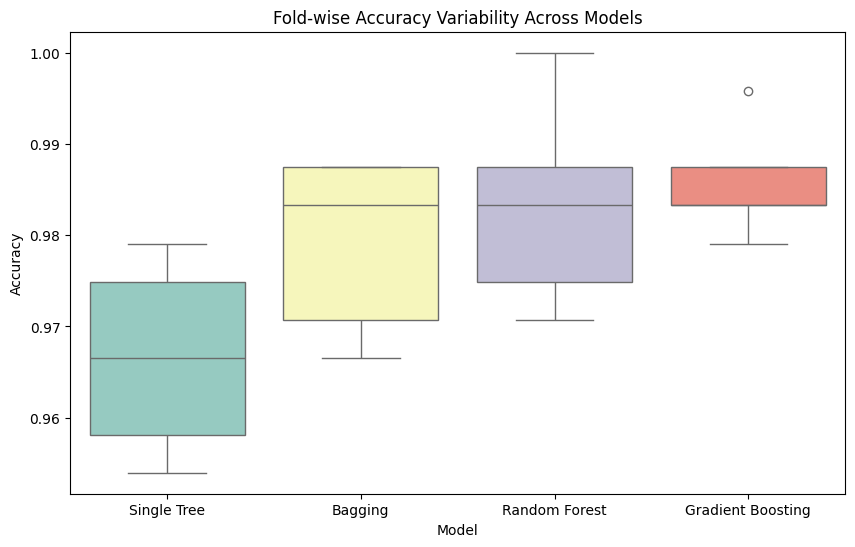

In [16]:
cv_results = pd.DataFrame({b"Single Tree": k_fold_single_tree_acc,
    "Bagging": k_fold_bagging_acc,
    "Random Forest": k_fold_rf_acc,
    "Gradient Boosting": k_fold_gb_acc
})

plt.figure(figsize=(10,6))
sns.boxplot(data=cv_results, palette="Set3")
plt.title("Fold-wise Accuracy Variability Across Models")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.show()

To emphasize the stability benefits of ensemble methods, the fold-wise variability illustrated above highlights a clear distinction across the four models. The three ensemble methods, Bagging, Random Forest, and Gradient Boosting, show both higher median values and tighter distributions compared to the single decision tree, signifying greater model stability and robustness under resampling. Most notably, Gradient Boosting demonstrates the most stable performance, with minimal fold-to-fold variability.

First look into the Classification Logic: Single Decision Tree Visualization


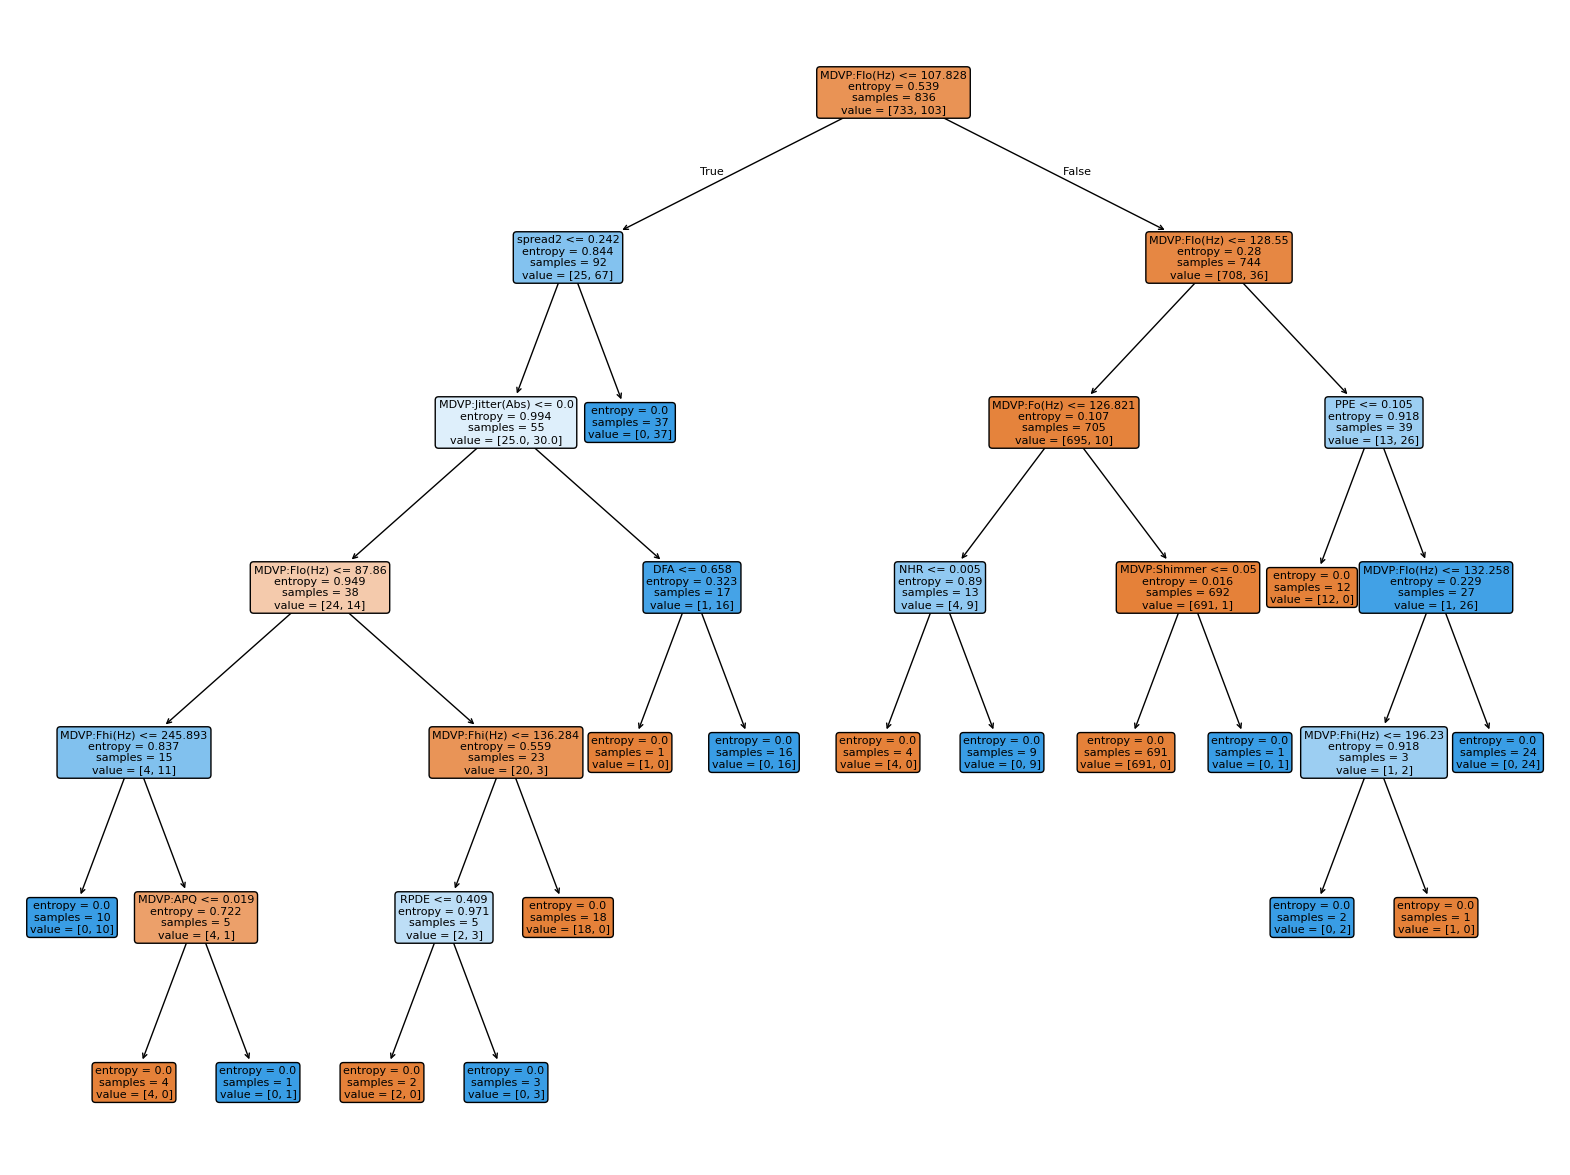

In [17]:
print("============================================================================")
print("First look into the Classification Logic: Single Decision Tree Visualization")
print("============================================================================")
ax = subplots(figsize=(20,15))[1]
plot_tree(clf_full,
          feature_names=feature_names,
          fontsize =8,
          filled=True,
          rounded=True,
          ax=ax);

To gain a more intuitive understanding of the model's internal workings, we  visualized the Single Decision Tree classifier. A first look reveals that the tree relies heavily on the ```MDVP:Flo(Hz)``` (Minimum fundamental frequency), which is consistent with previous literature and our results discussed in the previous sections.

This visualisation allows us to examine the hierarchical, step by step representation of the classification logic of the model, which is a valuable advantage, especially in a clinical setting. However, despite its interpretability, the decision tree model proved to have the lowest AUC scores among all tested models. This outcome shows a limitation of single decision trees, which are prone to overfitting.

In [18]:
print("=================================")
print("Hold-Out Test Set: ROC AUC Scores")
print("=================================")
print("Single Tree ROC AUC:", auc_single_tree)
print("Bagging ROC AUC:", auc_bag)
print("Random Forest ROC AUC:", auc_rf)
print("Gradient Boosting ROC AUC:", auc_gb)

Hold-Out Test Set: ROC AUC Scores
Single Tree ROC AUC: 0.9238816738816741
Bagging ROC AUC: 0.9976190476190476
Random Forest ROC AUC: 0.9974025974025973
Gradient Boosting ROC AUC: 0.9987012987012986


ROC-AUC is used as the primary metric for the hold-out test set performance of the models due to its usefulness in reflecting discriminative ability while maintaining relative robustness towards class imbalance. All ensemble models achieve near perfect ROC-AUC, which demonstrates the potential capabilities of voice biomarkers in diffrentiating healthy people and PD patients. That being said, a ranking can still be observed among the 4 models where the Gradient Boosting model again achieved the best ROC-AUC, followed by Bagging, Random Forest, and Decision Tree in that order.

The performance of this 30% hold-out test set aligns closely with the cross-validation results, suggesting good model performance stability and minimal signs of overfitting.

In [19]:
print("=========================================")
print("Hold-Out Test Set: Classification Reports")
print("=========================================", "\n")
print("Single Tree Classification Report:")
print(classification_report(parkinson_test, clf_full.predict(X_test)), "\n")

print("Bagging Classification Report:")
print(classification_report(parkinson_test, clf_bagging_full.predict(X_test)), "\n")

print("Random Forest Classification Report:")
print(classification_report(parkinson_test, clf_rf_full.predict(X_test)), "\n")

print("Gradient Boosting Classification Report:")
print(classification_report(parkinson_test, clf_gb_full.predict(X_test)))

Hold-Out Test Set: Classification Reports

Single Tree Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       315
           1       0.88      0.86      0.87        44

    accuracy                           0.97       359
   macro avg       0.93      0.92      0.93       359
weighted avg       0.97      0.97      0.97       359
 

Bagging Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       315
           1       0.89      0.95      0.92        44

    accuracy                           0.98       359
   macro avg       0.94      0.97      0.96       359
weighted avg       0.98      0.98      0.98       359
 

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       315
           1       0.91      0.95      0.93        44

    accuracy                    

To further assess our models' performance, we generated a classification report with precision, recall, and F1 scores. These metrics offer a more detailed evaluation of our models than accuracy alone. Accuracy shouldn't be prioritized in this setting, as it could be misleading due to our dataset's class imbalance.
From the results, we observe that ensemble methods (Bagging, Random Forest, and Gradient Boosting) outperform single trees. Gradient Boosting and Random Forest performed equally well with a 0.93 score for class 1 (Parkinson's).

Additionally, there is a substantial difference between ensemble models' and a single model's recall scores. High recall metrics for all of our ensemble models indicate their ability to identify PD cases, which is especially important in disease diagnostics. For instance, if the model classifies a Parkinson's patient as healthy, the patient might not receive the necessary treatment, which may lead to delayed diagnosis or disease progression.

Hold-Out Test Set: Precision-Recall Curves


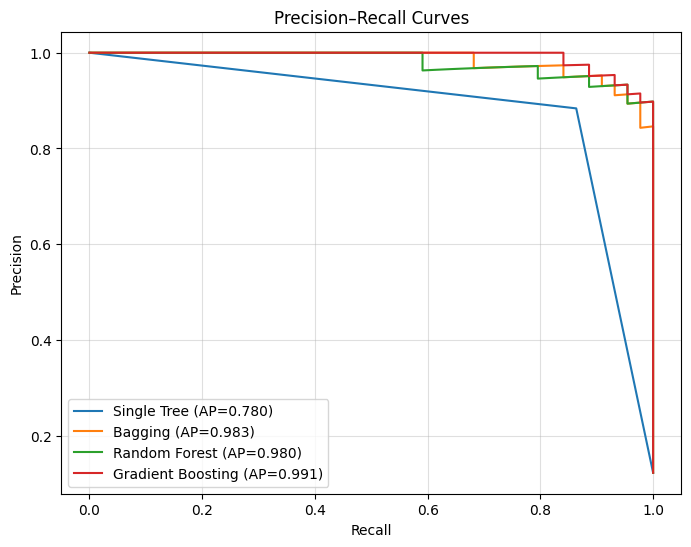

In [20]:
print("==========================================")
print("Hold-Out Test Set: Precision-Recall Curves")
print("==========================================")

plt.figure(figsize=(8,6))

plt.plot(rec_tree, prec_tree, label=f"Single Tree (AP={ap_tree:.3f})")
plt.plot(rec_bag,  prec_bag,  label=f"Bagging (AP={ap_bag:.3f})")
plt.plot(rec_rf,   prec_rf,   label=f"Random Forest (AP={ap_rf:.3f})")
plt.plot(rec_gb,  prec_gb, label=f"Gradient Boosting (AP={ap_gb:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

To reillustrate the importance of having Precision-Recall curves to further assess hold-out performances of the 4 models, it works exceptionally well due to PD cases being a minority, just 44 out of 359 test sample size, because it assess models' power to detect the positive class, which due to insymmetry problems, is arguably much more important than predicing the negative class well.

Right off the bat, we can see Gradient Boosting remains the best performing model as it also attained the strongest precision-recall trade-off and have the highest average precision at around 0.99. The other 2 ensemble models also performed extremely well with both of their curves leaning heavily towards the top-right corner. Singularly, the baseline decision tree performed worst among the 4 with an average precision of 0.78, which again motivates the usefulness of ensemble models in variance reduction and its contributions to help models generalize well to unseeen Parkinson Disease cases. 

Lastly, in medical screening context, such performances suggest the ensemble models were able to detect more PD cases (increased sensitivity) without sacrificing precision, which could be desirable in real world settings.

In [21]:
print("==================================")
print("Single Tree: Top 10 features")
print("==================================")
print(single_tree_importances.head(10), "\n")

print("==================================")
print("Random Forest: Top 10 features")
print("==================================")
print(rf_importances.head(10), "\n")

print("==================================")
print("Gradient Boosting: Top 10 features")
print("==================================")
print(gb_importances.head(10))

Single Tree: Top 10 features
MDVP:Flo(Hz)        0.611099
MDVP:Fo(Hz)         0.118321
PPE                 0.065845
spread2             0.051026
MDVP:Fhi(Hz)        0.043734
MDVP:Jitter(Abs)    0.029111
NHR                 0.025714
MDVP:Shimmer        0.024159
DFA                 0.012188
RPDE                0.010784
dtype: float64 

Random Forest: Top 10 features
MDVP:Flo(Hz)        0.146354
MDVP:Fhi(Hz)        0.089230
spread2             0.069844
MDVP:Fo(Hz)         0.068946
RPDE                0.047889
HNR                 0.047343
D2                  0.046900
spread1             0.044946
PPE                 0.042071
MDVP:Jitter(Abs)    0.039434
dtype: float64 

Gradient Boosting: Top 10 features
MDVP:Fhi(Hz)      0.320467
MDVP:Flo(Hz)      0.258387
spread2           0.170134
PPE               0.050625
D2                0.047776
RPDE              0.024115
MDVP:Jitter(%)    0.022959
NHR               0.021247
DFA               0.014191
Jitter:DDP        0.011833
dtype: float64


For all models, ```MDVP:Fhi (Hz)``` (maximum vocal fundamental frequency) and ``` MDVP:Flo(Hz) ``` (minimum vocal fundamental frequency) showed the highest importance for predicting Parkinson's. In addition to that, we also observed features such as spread2, RPDE, HNR, and D2 repeatedly appeared among the top-ranked variables, which could mean that these non-linear measures of vocal irregularity contribute more robustly when aggregated across many trees.

Our findings align with the previous literature on this topic, demonstrating that pitch-related voice biomarkers are strong predictors among other acoustic features of dysphonia associated with Parkinson's disease. For instance, Tracy et al. (2020) also highlighted fundamental frequency and its first-order derivative as features that contributed the most to predicting PD cases in a Gradient Boosting model.

Interestingly, while Chakole et al. (2025) highlighted PPE (Pitch Period Entropy) and DFA (Detrended Fluctuation Analysis) as particularly important features for prediction of PD,  most of our models assigned a lower importance to these features: only the single Decision Tree placed PPE among its top three predictors (0.065845).

In [22]:
df_caseA = df[(df['status'] == 0) | (df['status'] == 1)].copy()

y_caseA = df_caseA['status'].astype(int).values
X_caseA = df_caseA.drop(columns=['name', 'status']).values

X_trainA, X_testA, y_trainA, y_testA = train_test_split( X_caseA, y_caseA, test_size=0.3, stratify=y_caseA, random_state=14)

clfA = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500)
clfA.fit(X_trainA, y_trainA)

probaA = clfA.predict_proba(X_testA)[:, 1]
rocA = roc_auc_score(y_testA, probaA)
apA  = average_precision_score(y_testA, probaA)

print("Sensitivity Check: Effect of Different Labeling Approaches")
print("=============================================")
print("Original Case: Using only status = {0,1} rows")
print("=============================================")
print("ROC-AUC:", rocA)
print("Average Precision:", apA)
print()

df_caseB = df.copy()
df_caseB['binary_status'] = np.where(df_caseB['status'] >= 0.5, 1, 0)

y_caseB = df_caseB['binary_status'].values
X_caseB = df_caseB.drop(columns=['name', 'status', 'binary_status']).values

X_trainB, X_testB, y_trainB, y_testB = train_test_split(X_caseB, y_caseB, test_size=0.3, stratify=y_caseB, random_state=14)

clfB = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500)
clfB.fit(X_trainB, y_trainB)
probaB = clfB.predict_proba(X_testB)[:, 1]
rocB = roc_auc_score(y_testB, probaB)
apB  = average_precision_score(y_testB, probaB)

print("===============================")
print("Case B: Threshold status at 0.5")
print("===============================")
print("ROC-AUC:", rocB)
print("Average Precision:", apB)


Sensitivity Check: Effect of Different Labeling Approaches
Original Case: Using only status = {0,1} rows
ROC-AUC: 0.9712121212121213
Average Precision: 0.9896670010204893

Case B: Threshold status at 0.5
ROC-AUC: 0.9966873706004141
Average Precision: 0.9998674228777384


Moreover, we wanted to ensure that the model’s predictive performance is truly robust and not overly sensitive to our specific labeling choice. Hence, we introduced a “Case B” scenario to verify whether applying an alternative threshold at 0.5 would cause any degradation in performance.

Evidently, the model’s classification performance remained equally strong, with a ROC–AUC of around 0.997 and an Average Precision of approximately 0.99. Which are results that are very similar to those obtained under our original labeling choice, where status is strictly defined as 0 (healthy) or 1 (PD). This serves as reinforcement that the reliability of our main findings is not due to an artifact of a particular labeling assumption, but rather reflects a genuinely stable predictive signal in the vocal biomarkers.

In [23]:
clf_rf_balanced = RandomForestClassifier(max_depth=10,random_state=7,class_weight='balanced')
rf_balanced_acc = cross_val_score(clf_rf_balanced, X, parkinson, cv=skf,scoring='accuracy', n_jobs=-1)
rf_balanced_auc = cross_val_score(clf_rf_balanced, X, parkinson, cv=skf,scoring='roc_auc', n_jobs=-1)

clf_rf_no_weight = RandomForestClassifier(max_depth=10, random_state=7)
rf_no_weight_acc = cross_val_score(clf_rf_no_weight, X, parkinson, cv=skf, scoring='accuracy', n_jobs=-1)
rf_no_weight_auc = cross_val_score(clf_rf_no_weight, X, parkinson, cv=skf,scoring='roc_auc', n_jobs=-1)

print("Sanity Check: Class Weighting Effect")
print("============================")
print("WITH class_weight='balanced'")
print("============================")
print("Mean Accuracy:", rf_balanced_acc.mean())
print("Std Accuracy :", rf_balanced_acc.std())
print("Mean ROC-AUC:", rf_balanced_auc.mean())
print()
print("===============================")
print("WITHOUT class_weight='balanced'")
print("===============================")
print("Mean Accuracy:", rf_no_weight_acc.mean())
print("Std Accuracy :", rf_no_weight_acc.std())
print("Mean ROC-AUC:", rf_no_weight_auc.mean())


Sanity Check: Class Weighting Effect
WITH class_weight='balanced'
Mean Accuracy: 0.9832635983263598
Std Accuracy : 0.0102489110576702
Mean ROC-AUC: 0.9984406156456973

WITHOUT class_weight='balanced'
Mean Accuracy: 0.9857740585774059
Std Accuracy : 0.00861559007613974
Mean ROC-AUC: 0.9983838907613862


Last but not least, to assess whether class-imbalance handling had any meaningful effect on the performance of our Random Forest model, we trained a smaller comparative model both with and without `class_weight='balanced'`. The resulting differences were negligible, and the small fluctuations observed are entirely consistent with what one would expect from normal sampling variability. 

This reinforces that the Random Forest’s strong predictive performance originates from the genuine underlying signals within the vocal biomarker features, rather than from artefacts introduced by class-weight correction. It also provides a useful point of reflection for our sub-question raised in the Introduction, namely, whether class imbalance would meaningfully hinder the performance of models when the predictive signal is inherently strong. In this case, the answer appears to be no.

#### Limitations
Despite the encouraging cross-validation and hold-out performances of the ensemble models, several limitations of this project should be emphasised.

First, the dataset is of relatively small sample size with 1,195 samples from a single collection pipeline, in which one might have concerns on its abilities to generalize well under different environments. Moreover, the point we have been making throughtout the study of class imbalance can definitely produce latent results. Though ROC-AUC and PR curves have been used to combat this phenomena, true clinical evaluations should be under more sophisticated conditions or external validations before deployments into real world practice. 

In addition to the considerations above, an inherent characteristic of the dataset is that it contains multiple recordings per subject, and the modelling pipeline of this project, staying consistent with many prior studies on Parkinson’s Disease voice-marker analysis, treated each recording as an independent row. As a result, some degree of subject overlap between training and test sets is possible. However, the stability and robustness demonstrated by the ensemble methods under resampling make it unlikely that this overlap would invalidate the consistent structure of the vocal features used to classify PD, especially given their strong alignment with prior literature. Nonetheless, future extensions of this work could adopt subject-wise splitting methodologies to further strengthen generalisation under stricter evaluation settings.

The problem of multicollinearity, as mentioned previously, do not adversely affect tree-based models. However, it could inflate feature importance estimates due to clustering and correlated structures. Some usage of dimension reduction methods such as Principal Component Analysis and Linear Discriminant Analysis could be motivated to fine tune model complexity.

Lastly, a common complication of ensemble methods is their limitedness when it comes to model interpretability. While feature importance does offer insight, it does not capture the interactions between voice biomarkers learned by ensemble methods such as Random Forest or Gradient Boosting. For an ideal clinical setting, one might employ techniques introduced by Explainable AI where techniques such as LIME could provide more intuitions where required.

#### Conclusion

To sum everything up, this project effectively demonstrated that vocal biomarkers are constructive predictors for the early classification of Parkinson’s Disease when using tree-based and ensemble learning methods. Ensemble methods, particularly Bagging, Random Forest, and Gradient Boosting, achieved near-perfect ROC-AUC scores (≈0.99) and exceptionally strong Precision–Recall performance for both the positive class (Parkinson’s) and the negative class (healthy subjects) across both 5-fold cross-validation and hold-out testing. This serves as a meaningful extension to previous literature showing that acoustic features such as fundamental frequency measures (Fo, Fhi, Flo), pitch instability metrics (PPE, jitter), and nonlinear voice markers (D2, RPDE) carry strong predictive signals for Parkinson’s detection.

Ensemble models delivered clear improvements in variance reduction, stability, and overall classification quality compared to the single decision tree baseline, further solidifying the benefits of bootstrap aggregation and gradient-based optimization in biomedical prediction problems. Additionally, the feature-importance rankings and patterns across the ensemble methods were consistent and aligned with established clinical findings on the predictive capabilities of vocal biomarkers in Parkinson’s Disease, reinforcing the biological credibility of the results.

All in all, this study provides well-supported evidence that machine learning models—especially bagged or boosted ensemble methods, can be effectively leveraged for accurate Parkinson’s screening or early detection using vocal biomarkers. With further validation on external datasets, potential dimension-reduction or feature-engineering refinements, and, vitally, integration of explainability techniques, such models could serve as a convincing foundation for a scalable real-world clinical solution.

#### References

Chakole, M., Dorle, S., Agrawal, R., Dasarwar, P., Yadav, U., & Sharma, R. (2025). 
Vocal features based Parkinson’s detection: An ensemble learning approach. *MethodsX, 15*, 103662. 
https://doi.org/10.1016/j.mex.2025.103662 

Orozco-Arroyave, J. R. (2016). *Analysis of speech of people with Parkinson’s disease*. 
Logos Verlag Berlin.

Narendra, N. P., Schuller, B., & Alku, P. (2021). 
The detection of Parkinson’s disease from speech using voice source information. 
*IEEE/ACM Transactions on Audio, Speech, and Language Processing, 29*, 1925–1936. 
https://doi.org/10.1109/TASLP.2021.3078364

Orozco-Arroyave, J. R., Vásquez-Correa, J. C., Vargas-Bonilla, J. F., Arora, R., Dehak, N., 
Nidadavolu, P. S., Christensen, H., Rudzicz, F., Yancheva, M., Chinaei, H., Vann, A., Vogler, N., 
Bocklet, T., Cernak, M., Hannink, J., & Nöth, E. (2018). 
NeuroSpeech: An open-source software for Parkinson’s speech analysis. 
*Digital Signal Processing, 77*, 207–221. 
https://doi.org/10.1016/j.dsp.2017.07.004

Tracy, J. M., Özkanca, Y., Atkins, D. C., & Hosseini Ghomi, R. (2020). 
Investigating voice as a biomarker: Deep phenotyping methods for early detection of Parkinson’s disease. 
*Journal of Biomedical Informatics, 104*, 103362. 
https://doi.org/10.1016/j.jbi.2019.103362

UCI Machine Learning Repository. (n.d.). *Parkinson’s Disease Data Set*. 
Retrieved December 5, 2025, from https://archive.ics.uci.edu/dataset/174/parkinsons


